# Modele Densenet 121: 2 - Model on Raw images

As we work on Kaggle, this notebook has 2 parts: 
- a common part where we generat the raw images dataset for the DenseNet 121 model,
- a specific part where we:
    - perform the model training with the best hyperparameters on the raw images dataset
    - fine tune the model
    - do a grad cam analyses
    
## Common part: setting up the Working Environment and creating datasets

### Working Evironment

#### Colab

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 10 06:37:32 2024       

+---------------------------------------------------------------------------------------+

| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |

|-----------------------------------------+----------------------+----------------------+

| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |

| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |

|                                         |                      |               MIG M. |

|=========================================+======================+======================|

|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |

| N/A   33C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |

|                                         |                      |                  N/A |

+-----------------------------------------+--------------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM



You are using a high-RAM runtime!


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [ ]:
from google.colab import files

files.upload()
# import du kaggle.json dans C:\Users\Florent\.kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"floday","key":"07537b35a9bd77d1988340db0a763cf7"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'anasmohammedtahir/covidqu'

Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu

License(s): CC-BY-SA-4.0


 98% 1.13G/1.15G [00:11<00:00, 63.3MB/s]

100% 1.15G/1.15G [00:11<00:00, 103MB/s] 


In [ ]:
! mkdir covidqu_data
! unzip covidqu.zip -d covidqu_data

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00



In [ ]:
! mkdir working
! mkdir working/COVID-EX-Qu-dataset

#### Kaggle

In [ ]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

### Imports

In [ ]:
# Standard library imports
import os
import shutil

# Related third party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from tqdm import tqdm

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Keras Tuner imports
from keras_tuner import BayesianOptimization, HyperModel, RandomSearch


### Variables

In [ ]:
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']

# Colab
# base_path = '/content/covidqu_data/Lung Segmentation Data/Lung Segmentation Data'
# destination_path = '/content/working/COVID-EX-Qu-dataset'

# Kaggle
dataset_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
working_path = '/kaggle/working/COVID-EX-Qu-dataset'
source_images_path = os.path.join(working_path, 'source')

# Structure pour le modele
images_path = os.path.join(working_path, 'model','images')
clahe_images_path = os.path.join(working_path, 'model','normalized_images')
masked_normalized_images_path = os.path.join(working_path, 'model', 'masked_normalized_images')


### Data structure: creating the dataset

#### Copy source images and lung masks from Kaggle dataset

In [ ]:
def copy_images(base_path, destination_path, sets, groups, folders, replace=False):
    """
    Copies image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        folders (list): A list of image types inside 'groups' folders, e.g., ['images', 'lung masks'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        
        for group in groups:
            image_dir = os.path.join(base_path, sett, group)
            
            for folder in folders:
                source_path = os.path.join(image_dir, folder)
                destination_dir = os.path.join(destination_path, sett, group, folder)
                
                if os.path.exists(destination_dir):
                    if replace:
                        shutil.rmtree(destination_dir)
                        shutil.copytree(source_path, destination_dir)
                        print(f"Replaced the directory {destination_dir}")
                    else:
                        print(f"The directory {destination_dir} already exists.")
                else:
                    shutil.copytree(source_path, destination_dir)
                    print(f"Copied to {destination_dir}")

In [ ]:
copy_images(
    base_path=dataset_path, 
    destination_path=source_images_path, 
    sets=sets, 
    groups=groups, 
    folders=['images', 'lung masks'],
    replace=False
)

The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/COVID-19/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Normal/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Non-COVID/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/COVID-19/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/Normal/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/so

In [ ]:
def check_data_integrity(destination_path, sets, groups, ref_covid, ref_noncovid, ref_normal):
    """
    Checks the integrity of data by counting the number of images in each category
    and comparing them to reference values. Displays three random images from each set and group in grayscale,
    with all text outputs printed after image displays.

    Args:
        destination_path (str): The directory where image data has been copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        ref_covid (int): Reference number of COVID-19 images.
        ref_noncovid (int): Reference number of Non-COVID images.
        ref_normal (int): Reference number of Normal images.
    """
    n_covid = 0
    n_noncovid = 0
    n_normal = 0
    outputs = []

    for sett in sets:
        for group in groups:
            ima_dir = os.path.join(destination_path, sett, group, 'images')
            image_files = os.listdir(ima_dir)
            num_images = len(image_files)
            outputs.append(f"In the set {sett}, there are {num_images} images of {group}")

            if num_images > 0:
                # Randomly select 3 images to display, or fewer if there are less than 3.
                sample_images = random.sample(image_files, min(3, num_images))

                # Displaying the images using matplotlib
                fig, axes = plt.subplots(1, min(3, num_images), figsize=(15, 5))
                for idx, img_name in enumerate(sample_images):
                    img_path = os.path.join(ima_dir, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    axes[idx].imshow(img, cmap='gray')
                    axes[idx].axis('off')
                    axes[idx].set_title(f"{group} ({sett})")
                plt.show()

            if group == "COVID-19":
                n_covid += num_images
            elif group == "Non-COVID":
                n_noncovid += num_images
            elif group == "Normal":
                n_normal += num_images

    outputs.append(f"\nThere are {n_covid} COVID images found, {n_covid / ref_covid * 100:.2f}% of the original dataset from Kaggle.")
    outputs.append(f"There are {n_noncovid} non-COVID images, {n_noncovid / ref_noncovid * 100:.2f}% of the original dataset from Kaggle.")
    outputs.append(f"There are {n_normal} normal images, {n_normal / ref_normal * 100:.2f}% of the original dataset from Kaggle.")

    for output in outputs:
        print(output)

In [ ]:
check_data_integrity(destination_path=source_images_path, sets=sets, groups=groups, ref_covid=11956, ref_noncovid=11263, ref_normal=10701)

#### Data and folders structure for the model 

A specific data structure is expected for the model: one folder per set (Val, Test, Train) and a subfolder per group containing all the images. Therefore, this directory structure must be replicated for both the images and the masked images.

##### Raw images

In [ ]:
copy_images(
    base_path=source_images_path , 
    destination_path=images_path, 
    sets=sets, 
    groups=groups, 
    folders=['images'],
    replace=False)

The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/Non-COVID/images already exists.


##### Check processed images

In [ ]:
def display_random_images_from_sets(base_path, sets, groups, num_images=3):
    """
    Display random images from each set and group in the specified base path.

    Args:
        base_path (str): The base directory containing the images.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        num_images (int): The number of random images to display from each set and group.
    """
    for sett in sets:
        for group in groups:
            image_dir = os.path.join(base_path, sett, group, 'images')
            all_images = os.listdir(image_dir)
            random_images = random.sample(all_images, min(len(all_images), num_images))
            
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{sett} - {group}", fontsize=16)
            
            for i, image_name in enumerate(random_images):
                image_path = os.path.join(image_dir, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                plt.subplot(1, num_images, i + 1)
                plt.imshow(image, cmap='gray')
                plt.title(image_name)
                plt.axis('off')
            
            plt.show()

In [ ]:
display_random_images_from_sets(base_path=images_path, sets=sets, groups=groups, num_images=3)

## Specific part: Model 

### Data generator

In [ ]:
# pre processing pour DenseNet121
# d'apres Keras : input shape has to be (224, 224, 3)
# normalisation : deja fait
# densent est construit pour fonctionner en rgb : l faut donc repliquer la couche 3x comme les radios sont en gris

def preprocess_image(img):
    """
    Preprocess the image for DenseNet121 input.

    Args:
        img (numpy.array): Input image array.

    Returns:
        numpy.array: Preprocessed image array.
    """
    if img is None:
        raise ValueError("No image data received!")

    # Convert grayscale to RGB only if the image is grayscale
    if len(img.shape) == 2 or img.shape[2] == 1:  # Check if the image is grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Rescale pixel values to [0, 1]
    img = img / 255.0

    return img

In [ ]:
# Initialize the ImageDataGenerator with the preprocessing function

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    fill_mode='constant'  # You can include other augmentation settings here
)

In [ ]:
# Preparation of the data set using image generator

def data_generator(data_path:str, dataset:str, shuffle, batch_size=32):
    """
    Generates batches of tensor image data with real-time data augmentation.

    The data will be looped over (in batches) indefinitely.

    Args:
        data_path (str): Main directory name
        dataset (str): The subdirectory name (e.g., 'Train', 'Test', 'Val') within the destination path which contains the image data.
        shuffle (bool): Whether to shuffle the images before outputting to the batch.
        batch_size (int): Number of images to be included in each batch (default is 32, to optimize resources and a slow convergence for a better generalization).

    Returns:
        DirectoryIterator: An iterator that returns batches of preprocessed images and labels as per the specified batch size and target size.
    """
    generator = datagen.flow_from_directory(
        directory=os.path.join(data_path, dataset), # images stored in directories that represent their class labels
        target_size=(224, 224), # resizes all images to 224x224 pixels
        batch_size=batch_size, # defines how many images are processed at once
        class_mode='sparse', #'categorical' converts class labels to one-hot encoded vectors
        color_mode='rgb',  # Ensure images are loaded as grayscale
        shuffle=shuffle)

    return generator

In [ ]:
train_data_generator = data_generator(data_path=images_path, dataset="Train", shuffle=True)
test_data_generator = data_generator(data_path=images_path, dataset="Test", shuffle=False) # shuffle=False argument is very important for model evaluation
val_data_generator = data_generator(data_path=images_path, dataset="Val", shuffle=False)

Found 43430 images belonging to 3 classes.
Found 13576 images belonging to 3 classes.
Found 10834 images belonging to 3 classes.


In [ ]:
# verification
for x_batch, y_batch in data_generator(data_path=images_path, dataset='Train', shuffle=True):
    print(x_batch.shape)  # Should show (32, 224, 224, 3) if full batch
    print(y_batch.shape)  # Should show (32, num_classes) for one-hot encoded labels or (32,) for sparse labels
    break  # Just check the first batch

Found 43430 images belonging to 3 classes.
(32, 224, 224, 3)
(32,)


In [ ]:
def display_sample_images(data_path, groups, sets, num_samples=3):
    """
    Displays sample images for each class from each dataset.

    Args:
        groups (list): List of class names, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        sets (list): List of dataset names, e.g., ['Val', 'Test', 'Train'].
        num_samples (int): Number of images to display per class.
    """
    for set_name in sets:
        print(f"--- Displaying images from the {set_name} set ---")
        generator = data_generator(data_path=data_path, dataset=set_name, shuffle=False, batch_size=32)  # Batch size can be adjusted if necessary
        for group in groups:
            print(f"Class: {group}")
            found = 0
            images, labels = [], []
            # Reset the generator to ensure reproducibility
            generator.reset()
            for img_batch, label_batch in generator:
                for img, label in zip(img_batch, label_batch):
                    if generator.class_indices[group] == label:
                        images.append(img)
                        labels.append(label)
                        found += 1
                        if found >= num_samples:
                            break
                if found >= num_samples:
                    break
            # Display the images
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
            for i in range(num_samples):
                axes[i].imshow(images[i].squeeze())
                axes[i].axis('off')
                axes[i].set_title(f"{group}")
            plt.show()


In [ ]:
display_sample_images(data_path=images_path, groups=groups, sets=sets)

### Model building

In [ ]:
def build_model(hp):

    # Load the DenseNet121 base model, pre-trained on ImageNet
    base_model = DenseNet121(
        include_top=False, # top layers (classifiers) used to train the models on the original classes are not included
        weights='imagenet', # use the pre-training on ImageNet
        input_shape=(224, 224, 3))

    # Freeze the convolutional base to reuse the learned features
    for layer in base_model.layers:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(name='global_avg_pooling2d'),
        Dense(
            units=hp.Int('units_1', min_value=128, max_value=1024, step=128),
            activation='relu',
            name='dense_a1'
        ),
        Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1), name='dropout_a1'), # increase drop out rate to prevent overfitting
        Dense(
            units=hp.Int('units_2', min_value=64, max_value=256, step=64),
            activation='relu',
            name='dense_a2'
        ),
        Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1), name='dropout_2'),
        Dense(3, activation='softmax', name='output')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy', #
        metrics=['accuracy']
    )

    return model

### Tuning: already done

In [ ]:
# # instanciate the tuner

# tuner = BayesianOptimization(
#     build_model,
#     objective='val_accuracy',
#     max_trials=4, # Total number of trials including both initial random trials and subsequent Bayesian-optimized trials
#     num_initial_points=2, # Number of initial random trials before Bayesian optimization starts
#     directory='/content/working/COVID-EX-Qu-dataset',
#     project_name='densenet121_tuning',
#     overwrite=False  # Set to False to load existing data or resume previous search
# )

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# callback: Early stopping to speed up tuning
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # restore_best_weights : garde les weighs de l'epoch avec la meilleure val_loss

In [ ]:
# best hyperparameters for raw images (from 04_fd_densenet121_1_tuning.ipynb): 
best_units_1 = 512
best_dropout_1 = 0.5
best_units_2 = 128
best_dropout_2 = 0.5
best_learning_rate = 0.0014

### Model Training with the best hyperparameters

In [ ]:
def build_best_model(fine_tune=False):
    # Load the DenseNet121 base model, pre-trained on ImageNet
    base_model = DenseNet121(
        include_top=False,  # Exclude top layers
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Freeze the convolutional base to reuse the learned features
    if not fine_tune:
        for layer in base_model.layers:
            layer.trainable = False
    else:
      print("Unfreezing layers:")
      # Unfreeze the last dense block
      for layer in base_model.layers:
        if 'conv5_block16' in layer.name:
          layer.trainable = True
          print("trainable layer (must start- with 'conv5_block16'):" , layer.name)

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=best_units_1, activation='relu'),
        Dropout(rate=best_dropout_1),
        Dense(units=best_units_2, activation='relu'),
        Dropout(rate=best_dropout_2),
        Dense(3, activation='softmax')
    ])

    # Compile the model with a smaller learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.00001 if fine_tune else best_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
best_model = build_best_model(fine_tune=False)

In [ ]:
# Explicitly build model if not already built
if not best_model.built:
    best_model.build((None, 224, 224, 3))  # None for the batch size, and (224, 224, 3) is the input shape

best_model.summary()

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   

                                                                 

 global_average_pooling2d (  (None, 1024)              0         

 GlobalAveragePooling2D)                                         

                                                                 

 dense (Dense)               (None, 256)               262400    

                                                                 

 dropout (Dropout)           (None, 256)               0         

                                                                 

 dense_1 (Dense)             (None, 64)                16448     

                                                                 

 dropout_1 (Dropout)         (None, 64)                0         

                                      

In [ ]:
# New data generator with data augmentation to prevent overfitting during training :
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

In [ ]:
train_data_generator = data_generator(dataset="Train", shuffle=True)
test_data_generator = data_generator(dataset="Test", shuffle=False)
val_data_generator = data_generator(dataset="Val", shuffle=False)

Found 21715 images belonging to 3 classes.

Found 6788 images belonging to 3 classes.

Found 5417 images belonging to 3 classes.


In [ ]:
# verification
for x_batch, y_batch in data_generator('Train', shuffle=True):
    print(x_batch.shape)  # Should show (32, 224, 224, 3) if full batch
    print(y_batch.shape)  # Should show (32, num_classes) for one-hot encoded labels
    break  # Just check the first batch

Found 21715 images belonging to 3 classes.

(32, 224, 224, 3)

(32,)


In [ ]:
# Display the model's blocs and layers
def analyze_densenet_structure():
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
        print(layer.name)

analyze_densenet_structure()

input_10

zero_padding2d_14

conv1/conv

conv1/bn

conv1/relu

zero_padding2d_15

pool1

conv2_block1_0_bn

conv2_block1_0_relu

conv2_block1_1_conv

conv2_block1_1_bn

conv2_block1_1_relu

conv2_block1_2_conv

conv2_block1_concat

conv2_block2_0_bn

conv2_block2_0_relu

conv2_block2_1_conv

conv2_block2_1_bn

conv2_block2_1_relu

conv2_block2_2_conv

conv2_block2_concat

conv2_block3_0_bn

conv2_block3_0_relu

conv2_block3_1_conv

conv2_block3_1_bn

conv2_block3_1_relu

conv2_block3_2_conv

conv2_block3_concat

conv2_block4_0_bn

conv2_block4_0_relu

conv2_block4_1_conv

conv2_block4_1_bn

conv2_block4_1_relu

conv2_block4_2_conv

conv2_block4_concat

conv2_block5_0_bn

conv2_block5_0_relu

conv2_block5_1_conv

conv2_block5_1_bn

conv2_block5_1_relu

conv2_block5_2_conv

conv2_block5_concat

conv2_block6_0_bn

conv2_block6_0_relu

conv2_block6_1_conv

conv2_block6_1_bn

conv2_block6_1_relu

conv2_block6_2_conv

conv2_block6_concat

pool2_bn

pool2_relu

pool2_conv

pool2_pool

conv3_b

In [ ]:
# # dernier bloc du modele : conv5 block16 :
# Bottleneck (bn) followed by a standard convolution:

# Batch normalization and ReLU (preparation for the bottleneck conv).
# Bottleneck convolution (typically 1x1 convolutions used to reduce dimensionality).
# Batch normalization and ReLU (preparation for the 3x3 conv).
# Standard convolution (typically 3x3 convolutions that produce the growth in depth).
# Concatenation (combining the input with the output of the convolution for depth growth).

# Concatenation at the end


# unfreeze du dernier bloc pour le fine tuning "conv5_block16"

#### Training

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = best_model.fit(train_data_generator,
          validation_data=val_data_generator,
          epochs=30,
          callbacks=[stop_early])

best_model.save_weights('densenet_121_trained_weights.h5')

best_model.save('densenet_121_trained.h5')

Epoch 1/30

679/679 [==============================] - 81s 110ms/step - loss: 0.7293 - accuracy: 0.6878 - val_loss: 0.5318 - val_accuracy: 0.7968

Epoch 2/30

679/679 [==============================] - 75s 110ms/step - loss: 0.5672 - accuracy: 0.7710 - val_loss: 0.4624 - val_accuracy: 0.8222

Epoch 3/30

679/679 [==============================] - 74s 109ms/step - loss: 0.5194 - accuracy: 0.7942 - val_loss: 0.4231 - val_accuracy: 0.8344

Epoch 4/30

679/679 [==============================] - 75s 110ms/step - loss: 0.4836 - accuracy: 0.8079 - val_loss: 0.3984 - val_accuracy: 0.8455

Epoch 5/30

679/679 [==============================] - 74s 109ms/step - loss: 0.4595 - accuracy: 0.8183 - val_loss: 0.3823 - val_accuracy: 0.8549

Epoch 6/30

679/679 [==============================] - 74s 109ms/step - loss: 0.4380 - accuracy: 0.8292 - val_loss: 0.3743 - val_accuracy: 0.8584

Epoch 7/30

679/679 [==============================] - 74s 109ms/step - loss: 0.4248 - accuracy: 0.8323 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


#### Eval

In [ ]:
# Evaluation
results = best_model.evaluate(test_data_generator)

213/213 [==============================] - 20s 92ms/step - loss: 0.2953 - accuracy: 0.8894


In [ ]:
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Test loss: 0.2953045070171356

Test accuracy: 0.8893635869026184


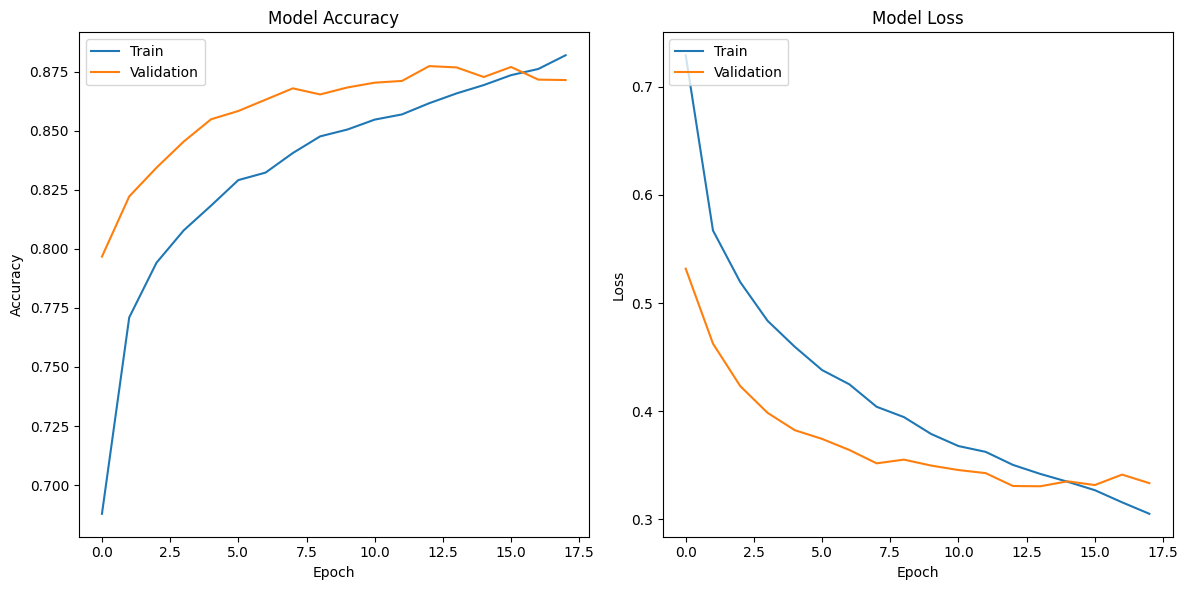

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Get the predictions and true classes
predictions = best_model.predict(test_data_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

213/213 [==============================] - 22s 92ms/step


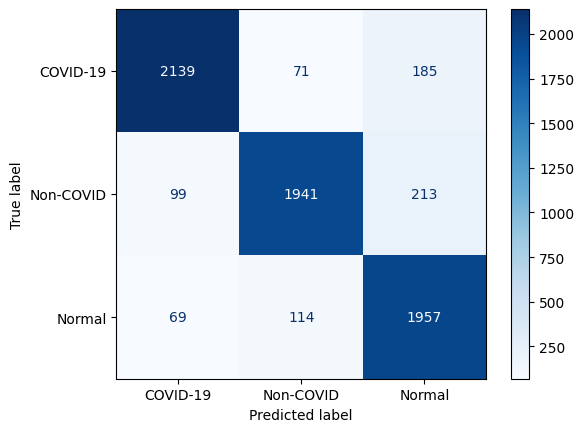

In [ ]:
# Compute the confusion matrix
cm = metrics.confusion_matrix(true_classes, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Generate and print the classification report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support



    COVID-19       0.93      0.89      0.91      2395

   Non-COVID       0.91      0.86      0.89      2253

      Normal       0.83      0.91      0.87      2140



    accuracy                           0.89      6788

   macro avg       0.89      0.89      0.89      6788

weighted avg       0.89      0.89      0.89      6788




### Fine tuning

In [ ]:
# fine tuning
# unfreeze le dernier bloc seulement ou qq layers de ce dernier bloc, comme l'échantillon est tres différent d'image net, sinon on, va overfit
# il faut diminuer le learning rate

best_model_fine_tuned = build_best_model(fine_tune=True)

Unfreezing layers:

trainable layer (must start- with 'conv5_block16'): conv5_block16_0_bn

trainable layer (must start- with 'conv5_block16'): conv5_block16_0_relu

trainable layer (must start- with 'conv5_block16'): conv5_block16_1_conv

trainable layer (must start- with 'conv5_block16'): conv5_block16_1_bn

trainable layer (must start- with 'conv5_block16'): conv5_block16_1_relu

trainable layer (must start- with 'conv5_block16'): conv5_block16_2_conv

trainable layer (must start- with 'conv5_block16'): conv5_block16_concat


#### Eval of the fine tuned model

In [ ]:
# train + evaluation etc.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = best_model_fine_tuned.fit(train_data_generator,
          validation_data=val_data_generator,
          epochs=20,
          callbacks=[stop_early])

best_model_fine_tuned.save_weights('densenet_121_fine_tuned_weights.h5')

best_model_fine_tuned.save('densenet_121_finee_tuned.h5')

Epoch 1/20

679/679 [==============================] - 200s 215ms/step - loss: 0.8242 - accuracy: 0.6359 - val_loss: 0.4510 - val_accuracy: 0.8453

Epoch 2/20

679/679 [==============================] - 145s 213ms/step - loss: 0.4390 - accuracy: 0.8335 - val_loss: 0.3081 - val_accuracy: 0.8881

Epoch 3/20

679/679 [==============================] - 145s 213ms/step - loss: 0.3168 - accuracy: 0.8806 - val_loss: 0.2112 - val_accuracy: 0.9225

Epoch 4/20

679/679 [==============================] - 146s 214ms/step - loss: 0.2494 - accuracy: 0.9104 - val_loss: 0.2106 - val_accuracy: 0.9208

Epoch 5/20

679/679 [==============================] - 145s 213ms/step - loss: 0.1989 - accuracy: 0.9271 - val_loss: 0.2108 - val_accuracy: 0.9197

Epoch 6/20

679/679 [==============================] - 145s 214ms/step - loss: 0.1613 - accuracy: 0.9412 - val_loss: 0.1920 - val_accuracy: 0.9302

Epoch 7/20

679/679 [==============================] - 145s 213ms/step - loss: 0.1234 - accuracy: 0.9560 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [ ]:
# Evaluation
results_fine_tuned = best_model_fine_tuned.evaluate(test_data_generator)

213/213 [==============================] - 19s 88ms/step - loss: 0.1548 - accuracy: 0.9452


In [ ]:
print(f"Test loss: {results_fine_tuned[0]}")
print(f"Test accuracy: {results_fine_tuned[1]}")

Test loss: 0.1548365354537964

Test accuracy: 0.9451974034309387


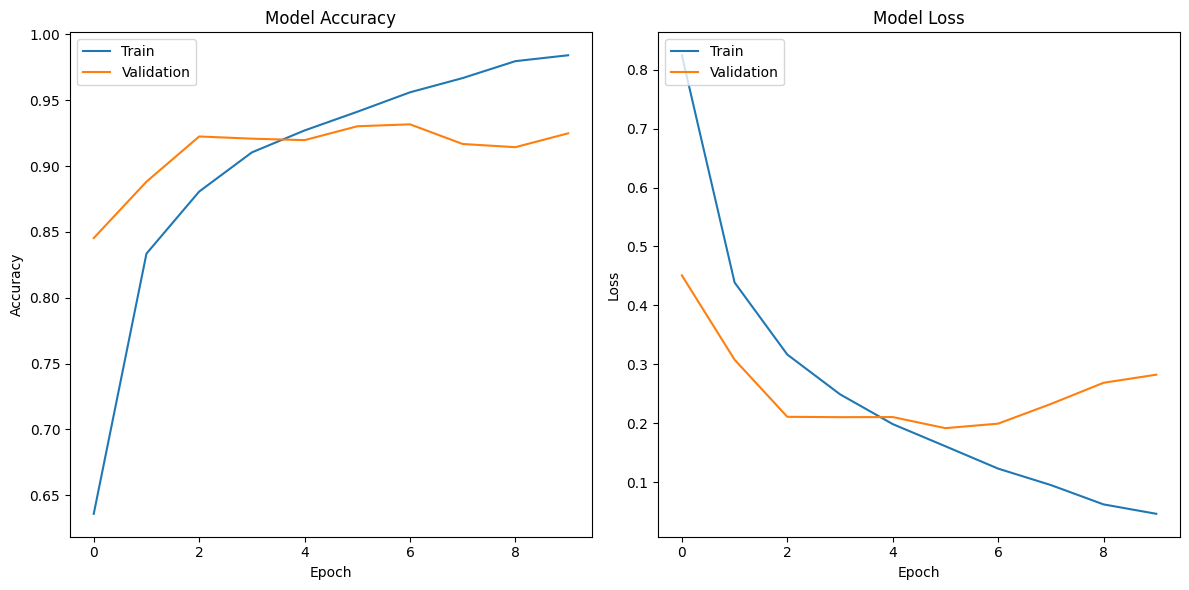

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Get the predictions and true classes
predictions = best_model_fine_tuned.predict(test_data_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())


213/213 [==============================] - 21s 88ms/step


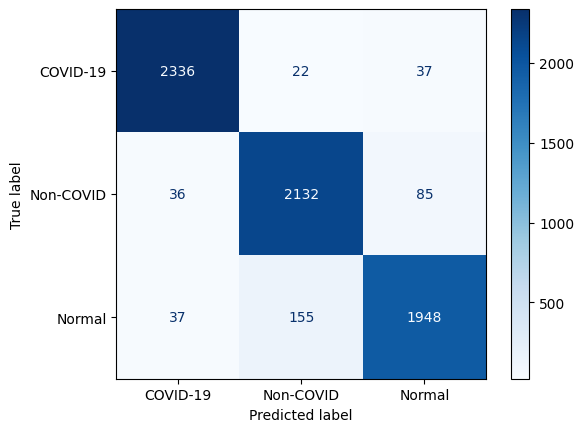

In [ ]:
# Compute the confusion matrix
cm = metrics.confusion_matrix(true_classes, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
# Generate and print the classification report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support



    COVID-19       0.97      0.98      0.97      2395

   Non-COVID       0.92      0.95      0.93      2253

      Normal       0.94      0.91      0.93      2140



    accuracy                           0.95      6788

   macro avg       0.94      0.94      0.94      6788

weighted avg       0.95      0.95      0.95      6788




### Interpretability: GRAD CAM

In [ ]:
class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}

In [ ]:
model = best_model_fine_tuned

for layer in model.layers:
    print(layer.name)

NameError: name 'best_model_fine_tuned' is not defined

In [ ]:
# Access the DenseNet121 base model which is the first layer of the sequential model
base_model = model.get_layer('densenet121')

# List all layers inside the base model to find the last convolutional layer
for layer in base_model.layers:
    print(layer.name)


input_11

zero_padding2d_16

conv1/conv

conv1/bn

conv1/relu

zero_padding2d_17

pool1

conv2_block1_0_bn

conv2_block1_0_relu

conv2_block1_1_conv

conv2_block1_1_bn

conv2_block1_1_relu

conv2_block1_2_conv

conv2_block1_concat

conv2_block2_0_bn

conv2_block2_0_relu

conv2_block2_1_conv

conv2_block2_1_bn

conv2_block2_1_relu

conv2_block2_2_conv

conv2_block2_concat

conv2_block3_0_bn

conv2_block3_0_relu

conv2_block3_1_conv

conv2_block3_1_bn

conv2_block3_1_relu

conv2_block3_2_conv

conv2_block3_concat

conv2_block4_0_bn

conv2_block4_0_relu

conv2_block4_1_conv

conv2_block4_1_bn

conv2_block4_1_relu

conv2_block4_2_conv

conv2_block4_concat

conv2_block5_0_bn

conv2_block5_0_relu

conv2_block5_1_conv

conv2_block5_1_bn

conv2_block5_1_relu

conv2_block5_2_conv

conv2_block5_concat

conv2_block6_0_bn

conv2_block6_0_relu

conv2_block6_1_conv

conv2_block6_1_bn

conv2_block6_1_relu

conv2_block6_2_conv

conv2_block6_concat

pool2_bn

pool2_relu

pool2_conv

pool2_pool

conv3_b

In [ ]:
test_input = tf.random.normal([1, 224, 224, 3])  # Example tensor mimicking an input image

try:
    # Check outputs to validate the model setup
    conv_output, final_output = grad_model(test_input)
    print("Model constructed successfully. Outputs checked.")
except Exception as e:
    print("Error in model execution:", e)


Model constructed successfully. Outputs checked.


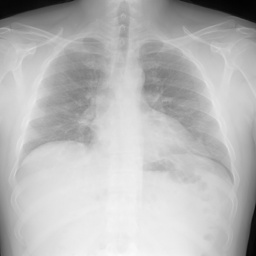

In [ ]:
from IPython.display import Image, display

img_size = (224, 224)  # Input size for DenseNet121
preprocess_input = preprocess_input  # Preprocessing function for DenseNet121

# Local path to your target image
img_path = '/content/working/COVID-EX-Qu-dataset/Test/COVID-19/images/covid_10.png'

# Display the target image
display(Image(filename=img_path))


In [ ]:
last_conv_layer_name = "conv5_block16_concat" # last convolutional layer for DenseNet121
grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])


ValueError: No such layer: conv5_block16_concat. Existing layers are: ['densenet121', 'global_average_pooling2d_1', 'dense_3', 'dropout_2', 'dense_4', 'dropout_3', 'dense_5'].

In [ ]:
model = best_model_fine_tuned
layer_name = 'conv5_block16_concat'
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[model.get_layer(layer_name).output, model.output]
)

def compute_gradcam(image, class_index, grad_model):
    with tf.GradientTape() as tape:
        # Ensure the correct layers' outputs are being watched
        conv_outputs, predictions = grad_model(image)
        tape.watch(conv_outputs)  # Make sure to watch the conv layer output
        loss = predictions[:, class_index]

    # Compute gradients with respect to the conv layer outputs
    grads = tape.gradient(loss, conv_outputs)

    if grads is None:
        raise ValueError("No gradients: Check layer name and model output")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output_value = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_output_value * tf.expand_dims(tf.expand_dims(pooled_grads, axis=0), axis=0), axis=-1)
    heatmap = tf.nn.relu(heatmap)  # Apply ReLU to clean negative values
    heatmap /= tf.math.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap


ValueError: No such layer: conv5_block16_concat. Existing layers are: ['densenet121', 'global_avg_pooling2d', 'dense_1', 'dropout_1', 'dense_2', 'dropout_2', 'output'].

In [ ]:
num_images_to_process = 10

# Iterate through the images
for i in range(num_images_to_process):
    # Randomly select a batch from the test data generator
    batch_images, batch_labels = next(iter(test_data_generator))
    # Take the first image from the batch (fixing the earlier logic error)
    img_array = batch_images[i]
    batch_label = batch_labels[i]  # Corresponding label

    # Preprocess the image and predict
    image = np.expand_dims(img_array, axis=0)
    preds = model.predict(image)
    predicted_class = np.argmax(preds[0])

    # Compute Grad-CAM heatmap
    heatmap = compute_gradcam(image, predicted_class, grad_model)

    # Resize the heatmap to match the input image size
    heatmap = tf.expand_dims(heatmap, axis=-1)  # Ensure heatmap has 3 channels
    heatmap = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]))

    # Convert the heatmap to a numpy array and normalize it
    heatmap = heatmap.numpy()
    heatmap = np.squeeze(heatmap)  # Remove unnecessary dimensions
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap)) * 255
    heatmap = np.uint8(heatmap)  # Convert to unsigned 8-bit integer

    # Apply a color map to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert heatmap to float32 to blend with the original image
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(np.float32(img_array), 0.6, heatmap, 0.4, 0)

    # Extract class labels for display
    class_label = class_names[predicted_class]
    true_class_name = class_names[int(batch_label)]

    title_color = 'green' if true_class_name == class_label else 'red'

    # Display the results
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Image {i+1} - Predicted label: {class_label} | True label: {true_class_name}', fontsize=16, x=0.5, y=0.98, horizontalalignment='center', color=title_color)
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 33ms/step


InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (2 for input with 2 dimension(s) [Op:Mean]